In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter

In [2]:
def load_xvg_file(filename,skip=1, ncols=2):
    '''
    function to load xvg files
    '''
    x, y ,z = [], [], []

    if ncols==2:
        with open(filename) as f:
            for line in f:
                cols = line.split()
                if len(cols)==2:
                    x.append(cols[0])
                    y.append(cols[1])
        return np.array(x[skip:],dtype=float),np.array(y[skip:],dtype=float)
    elif ncols==3:
        with open(filename) as f:
            for line in f:
                cols = line.split()
                if len(cols)==3:
                    x.append(cols[0])
                    y.append(cols[1])
                    z.append(cols[2])
        return np.array(x[skip:],dtype=float),np.array(y[skip:],dtype=float),np.array(z[skip:],dtype=float)


In [3]:
def gaussian(x,a,b,c):
    return np.abs(a)*np.exp(-4*np.log(2)*(x-b)**2./(c**2))

def fit(function,x,y,p0=None,sigma=None,bounds=None):
    '''
    fits a function and return the fit resulting parameters and curve
    '''
    popt,pcov = curve_fit(function,x,y,p0=p0,sigma=sigma)
    #x = np.arange(min(x),max(x),x[1]-x[0])
    curve = function(x,*popt)
    perr = np.sqrt(np.diag(pcov))
    return popt,x,curve,perr

In [4]:
def wr(r):
    'window function, see SI https://doi.org/10.1063/1.3594545 '
    w = np.zeros(len(r))
    r_max = r[-1] # here is assumed that the r[-1] is half the box size (plz check)
    i = int(len(r)/3)
    w[:i] = 1-3*(r[:i]/r_max)**2
    w[i:] = 3/2*(1-2*r[i:]/r_max+(r[i:]/r_max)**2)
    return w

def get_Sq_from_gr(r,gr, rho, window = True, qres = 10): 
    """
    Returns the structure factor S(q) from a giver rdf g(r)
    window: option to use window function
    qres: factor by which to increase the q-resolution
    """
    sq = np.zeros(len(r))
    q = np.linspace(2.0*np.pi/r[-1], 2.0*np.pi/(r[1]-r[0])/qres, len(r))
    dr = r[1]-r[0]
    if window == True:
        for i in range(len(r)):
            hr = r*(gr-1)*np.sin(q[i]*r)*dr/q[i]
            sq[i] = 1+4*np.pi*rho*np.trapz(wr(r)*hr)
    elif window == False:
        for i in range(len(r)):
            hr = r*(gr-1)*np.sin(q[i]*r)*dr/q[i]
            sq[i] = 1+4*np.pi*rho*np.trapz(hr)
    return q,sq

330.98122213810313


Text(0.5, 0, 'time (ns)')

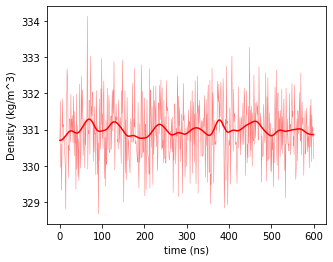

In [15]:
plt.figure(figsize=[5,4])

#path = "/cfs/data/pg/sdaqs/sol-nix/MD-glyc-water/mdf/"
filename = "../mdf/volume_230K.xvg"
t,volume = load_xvg_file(filename)
print(np.average(volume))
plt.plot(t/1e3,volume,lw=0.5,c='red',alpha=0.5)
plt.plot(t/1e3,gaussian_filter(volume,sigma=10),lw=1.5,c='red')

plt.ylabel('Density (kg/m^3)')
plt.xlabel('time (ns)')


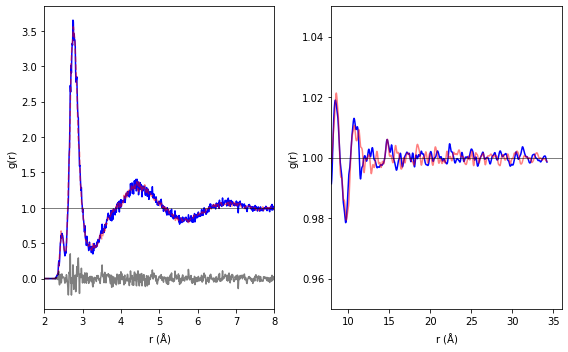

In [32]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(8, 5))

filename = "../mdf/rdf/rdf_230K_100.xvg"
r,gr = load_xvg_file(filename)
r, gr = r[:-1], gr[:-1] # I noticed that the last data point in teh g(r) is off

filename = "../mdf/rdf/rdf_230K_200.xvg"
r2,gr2 = load_xvg_file(filename)
r2, gr2 = r2[:-1], gr2[:-1]
gr2 = np.interp(r,r2,gr2) #interpolated both frames in the same axis

ax1.plot(r*10,gr, '-',c='blue')
ax1.plot(r*10,gr2, '--',c='red',alpha=0.5)
ax1.plot(r*10,gr-gr2,c='black',alpha=0.5 )
ax1.set_xlim(2,8)
#ax1.set_ylim(-0.01,0.01)
ax1.set_ylabel('g(r)')
ax1.set_xlabel(r'r ($\rm \AA$)')
ax1.axhline(y=1,c= 'black',lw=1,alpha=0.5)

ax2.plot(r*10,gaussian_filter(gr,sigma=10), '-',c='blue')
ax2.plot(r*10,gaussian_filter(gr2,sigma=10), '-',c='red',alpha=0.5)
ax2.set_xlim(8,36)
ax2.set_ylim(0.95,1.05)
ax2.set_ylabel('g(r)')
ax2.set_xlabel(r'r ($\rm \AA$)')
ax2.axhline(y=1,c= 'black',lw=1,alpha=0.5)

plt.tight_layout()

gmx command to calculate the rdf
```bash
gmx rdf -f md_230K.xtc -s md_230K.tpr -o rdf/rdf_230K_200_heavy.xvg -bin 0.001 -ref 'name OW or name O1 or name C2 or name C3 or name O4 or name C5 or name O6' -sel 'name OW or name O1 or name C2 or name C3 or name O4 or name C5 or name O6' -b 200000 -e 200000 -cut 0.2
```

In [33]:
# variables and constants
T = 230             # temperature in K
n = 10000           # number of water molecules
k_T = 6.12152e-10   # compressibility (m^3/J)
kB = 1.3806452e-23  # Boltzmann constant (J/K)

# volume and number density
V = np.average(volume) # volume
L = np.cbrt(V)         # box size (nm)
rho_ = n/V             # number density (molecules/nm^3)

# the minimum q is defined by 2*pi/r_max where r_max = L/2 (half the box size)
qmin = 2*np.pi/(L/2.)

# get the s(q=0) from the compressibility 
nT = rho_*1e27      # change units to molecules/m^3
S0 = nT*kB*k_T*T 

# print results
print(r'box size: %.2fA, r_max: %.2fA '%(L/2.,r[-1])) # check if r_max is about half the box size
print(r'number density = %.2f molecules/nm^3'%rho_)
print(r'q_min = %.2f/nm'%(qmin))
print(r'S0 = %.2f'%S0)

box size: 3.46A, r_max: 3.42A 
number density = 30.21 molecules/nm^3
q_min = 1.82/nm
S0 = 0.06


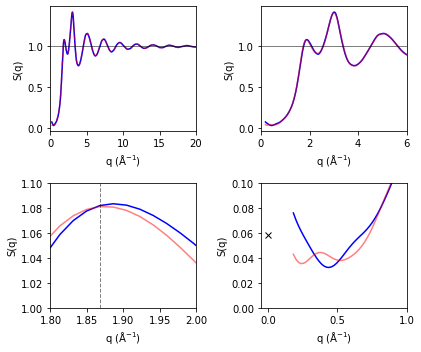

In [37]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(6, 5))

#filename = "../mdf/rdf.xvg"
#r,gr = load_xvg_file(filename)
#ax1.plot(r*10,gr, '-',c='red')

q,sq = get_Sq_from_gr(r,gr,n/volume[100])
q2,sq2 = get_Sq_from_gr(r,gr2,n/volume[200])

ax1.plot(q/10,sq, '-',c='blue', ms=2)
ax1.plot(q2/10,sq2, '--',c='red', alpha=0.5)
ax1.set_xlim(0,20)
ax1.set_ylabel('S(q)')
ax1.set_xlabel(r'q ($\rm \AA^{-1}$)')
ax1.axhline(y=1,c= 'black',lw=1,alpha=0.5)

ax2.plot(q/10,sq, '-',c='blue', ms=2)
ax2.plot(q2/10,sq2, '-',c='red', alpha=0.5)
ax2.set_xlim(0,6)
ax2.set_ylabel('S(q)')
ax2.set_xlabel(r'q ($\rm \AA^{-1}$)')
ax2.axhline(y=1,c= 'black',lw=1,alpha=0.5)

ax3.plot(q/10,sq, '-',c='blue', ms=2)
ax3.plot(q2/10,sq2, '-',c='red', alpha=0.5)
S1 = q[sq2 == max(sq2[:120])]
ax3.axvline(x=S1/10,c= 'black',lw=1,alpha=0.5,ls='--')
ax3.set_xlim(1.8,2)
ax3.set_ylim(1,1.1)
ax3.set_ylabel('S(q)')
ax3.set_xlabel(r'q ($\rm \AA^{-1}$)')

ax4.plot(q/10,sq, '-',c='blue')
ax4.plot(q2/10,sq2, '-',c='red', alpha=0.5)
sq_avg = (sq+sq2)/2.
ax4.plot(0,S0,'x',c='black')
ax4.set_xlim(-0.05,1)
ax4.set_ylim(0.,0.1)
ax4.set_ylabel('S(q)')
ax4.set_xlabel(r'q ($\rm \AA^{-1}$)')

plt.tight_layout()

In [36]:
S1 = q[sq2 == max(sq2[:120])]
print(S1/10)

[1.86790086]
